In [28]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

# Define stock tickers
tickers = ["RACE", "TSLA", "JNJ", "XOM", "^GSPC"]

# Fetch weekly adjusted closing prices from Yahoo Finance
start_date = "2015-01-02"
end_date = "2025-01-02"  # 10-year window

data = yf.download(tickers, start=start_date, end=end_date, interval="1wk")["Close"]

# Fetch risk-free rate from FRED (US 3-Month Treasury Rate)
rf = pdr.get_data_fred("DTB3", start=start_date, end=end_date)

# Convert annualized risk-free rate to weekly
rf["Weekly Rate"] = rf["DTB3"] / 52 / 100

# Calculate weekly returns
returns = data.pct_change().dropna()

# Merge risk-free rate
returns = returns.join(rf["Weekly Rate"]).dropna()

returns.head()


[*********************100%***********************]  5 of 5 completed
/var/folders/lv/9l9m89mn29v2v40gwtlxv2300000gn/T/ipykernel_68999/938589637.py:21: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


,JNJ,RACE,TSLA,XOM,^GSPC,Weekly Rate
Date,,,,,,
2015-10-22,0.029192,0.000000,0.013661,0.025807,0.035370,0.000000
2015-10-26,0.000000,-0.105534,0.000000,0.000000,0.000000,0.000004
2015-10-29,0.014530,0.000000,0.087669,0.044968,0.005722,0.000013
2015-11-02,0.000000,0.039659,0.000000,0.000000,0.000000,0.000015
2015-11-05,-0.000785,0.000000,-0.054181,-0.050709,-0.012990,0.000010


In [30]:
#beta estimation
import statsmodels.api as sm

betas = {}

for stock in tickers[:-1]:  # Exclude market index (^GSPC)
    X = returns["^GSPC"] - returns["Weekly Rate"]  # Market excess return
    y = returns[stock] - returns["Weekly Rate"]  # Stock excess return

    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X).fit()
    
    betas[stock] = model.params  # Store alpha and beta
    
    print(f"\n{stock} Regression Results:")
    print(model.summary())


RACE Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.04635
Date:                Sun, 09 Feb 2025   Prob (F-statistic):              0.830
Time:                        14:57:47   Log-Likelihood:                 1931.8
No. Observations:                 886   AIC:                            -3860.
Df Residuals:                     884   BIC:                            -3850.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020     

In [42]:
beta_value = model.params.iloc[-1]  # Always select the last coefficient

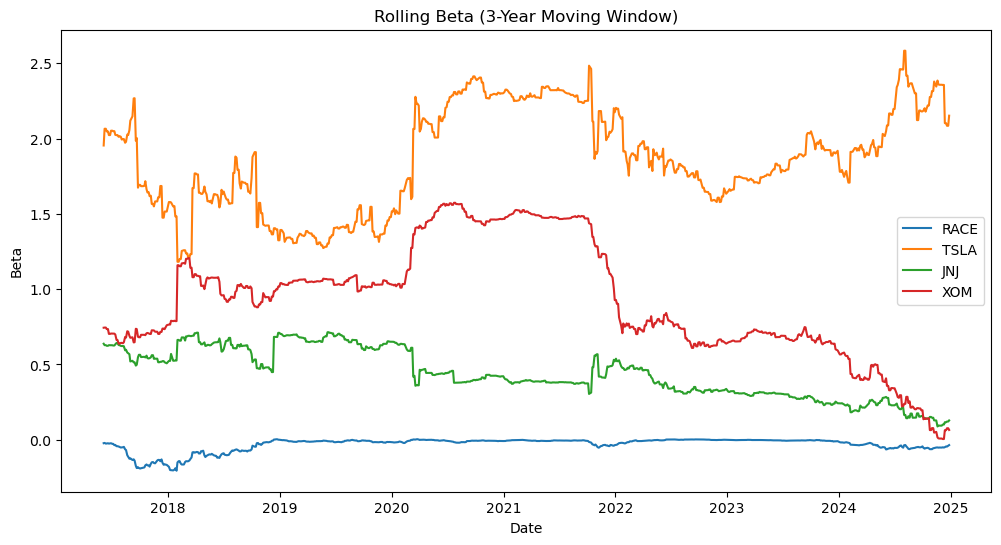

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

window_size = 157  # 3 years of weekly data
rolling_betas = {stock: [] for stock in tickers[:-1]}  # Store beta values
dates = []

for i in range(len(returns) - window_size):
    window_data = returns.iloc[i : i + window_size]

    X = window_data["^GSPC"] - window_data["Weekly Rate"]
    if X.std() == 0:  
        continue  # Skip if no variance in market returns
    
    X = sm.add_constant(X)  # Add intercept
    
    for stock in tickers[:-1]:  # Exclude the market index
        y = window_data[stock] - window_data["Weekly Rate"]
        
        if y.std() == 0:  # Skip if no variation in stock returns
            rolling_betas[stock].append(np.nan)
            continue
        
        model = sm.OLS(y, X).fit()
        
        # FIX: Ensure correct indexing
        beta_value = model.params.iloc[-1]  # Get last parameter (beta)
        
        rolling_betas[stock].append(beta_value)

    dates.append(window_data.index[-1])

# Convert to DataFrame
rolling_betas_df = pd.DataFrame(rolling_betas, index=dates)

# Plot Rolling Beta Graph
plt.figure(figsize=(12,6))
for stock in rolling_betas_df.columns:
    plt.plot(rolling_betas_df.index, rolling_betas_df[stock], label=stock)

plt.xlabel("Date")
plt.ylabel("Beta")
plt.title("Rolling Beta (3-Year Moving Window)")
plt.legend()
plt.show()


In [54]:
df = pd.read_excel('Documents/Project_Work/823_analytics_for_financial_markets/Credit Card Data.xlsx')

# Display the first few rows to understand the structure
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Summary Statistics:
                 ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

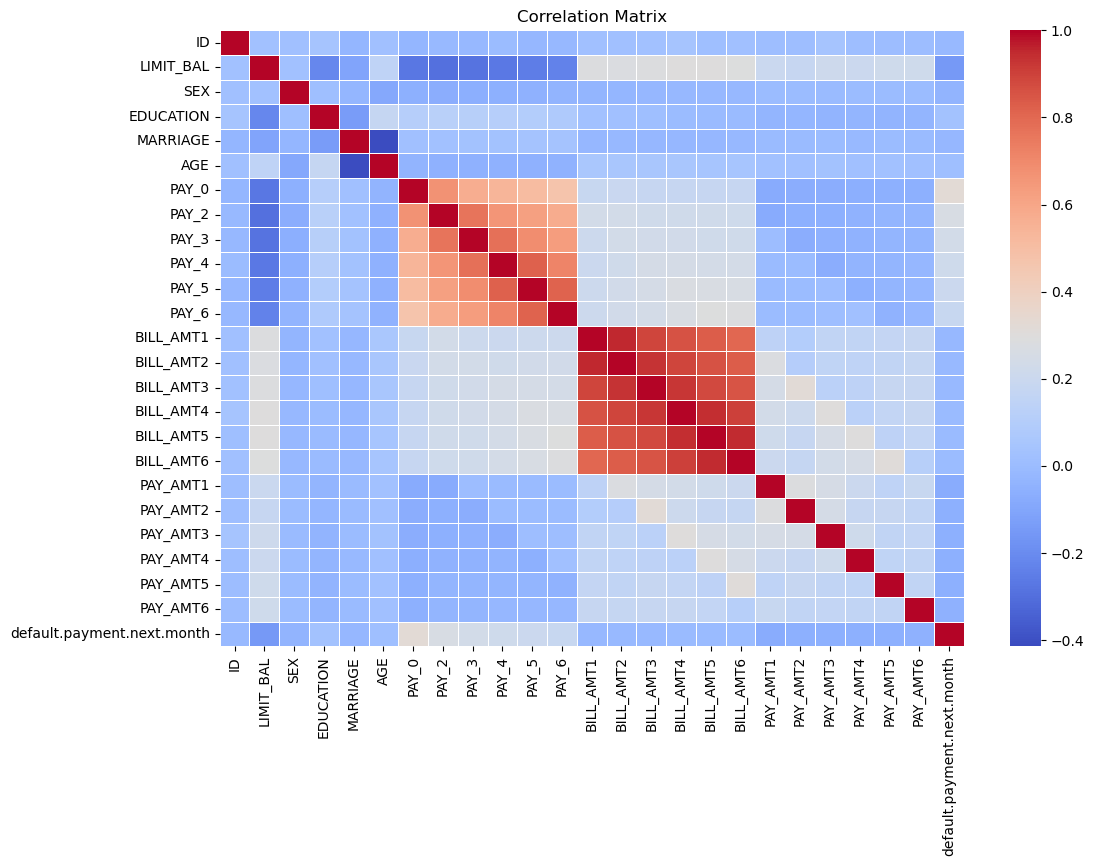

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics
summary_stats = df.describe()

# Check for missing values
missing_values = df.isnull().sum()

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Matrix")

# Display results
print("Summary Statistics:")
print(summary_stats)

missing_values

In [68]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Drop ID column as it's not useful for modeling
df = df.drop(columns=['ID'])

# Define categorical and numerical columns
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['default.payment.next.month']]

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Define logistic regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=1000))])

# Define train-test split (first 20000 for training, next 10000 for testing)
train_data = df.iloc[:20000]
test_data = df.iloc[20000:30000]

X_train = train_data.drop(columns=['default.payment.next.month'])
y_train = train_data['default.payment.next.month']

X_test = test_data.drop(columns=['default.payment.next.month'])
y_test = test_data['default.payment.next.month']

# Train the model
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# Display accuracy and classification report
accuracy, report


(0.8208,
 {'0': {'precision': 0.8264110756123536,
   'recall': 0.979550618530674,
   'f1-score': 0.8964879852125693,
   'support': 7922},
  '1': {'precision': 0.7344262295081967,
   'recall': 0.21559191530317612,
   'f1-score': 0.3333333333333333,
   'support': 2078},
  'accuracy': 0.8208,
  'macro avg': {'precision': 0.7804186525602752,
   'recall': 0.5975712669169251,
   'f1-score': 0.6149106592729513,
   'support': 10000},
  'weighted avg': {'precision': 0.8072966245919098,
   'recall': 0.8208,
   'f1-score': 0.7794644485520641,
   'support': 10000}})

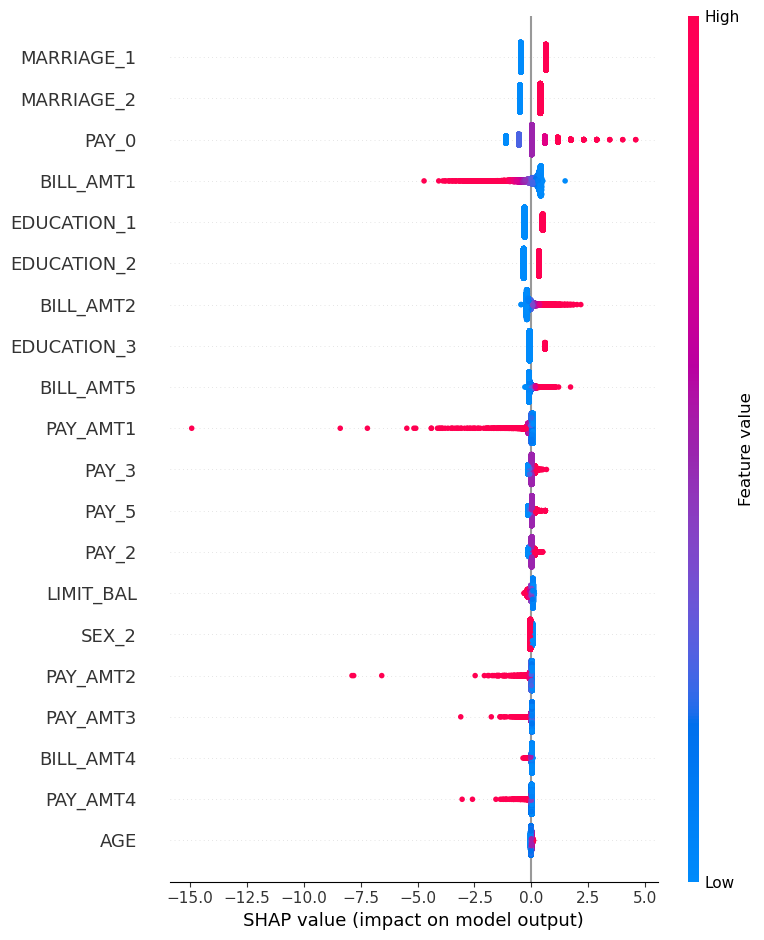

In [76]:
import shap

# Get transformed dataset
X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

# Extract feature names after preprocessing
feature_names = numerical_cols + list(
    model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
)

# Convert to DataFrame for compatibility
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Compute SHAP values
explainer = shap.Explainer(model.named_steps['classifier'], X_test_transformed_df)
shap_values = explainer(X_test_transformed_df)

# Summary plot for feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_transformed_df)


Feature Importance:
        Feature  Importance
27   MARRIAGE_1    1.101525
29   MARRIAGE_3    0.966104
28   MARRIAGE_2    0.899229
21  EDUCATION_1    0.794056
24  EDUCATION_4    0.681139
23  EDUCATION_3    0.676287
22  EDUCATION_2    0.667183
2         PAY_0    0.640085
8     BILL_AMT1    0.491892
25  EDUCATION_5    0.387015
26  EDUCATION_6    0.349239
14     PAY_AMT1    0.262005
9     BILL_AMT2    0.246233
15     PAY_AMT2    0.138900
12    BILL_AMT5    0.131720
4         PAY_3    0.099251
6         PAY_5    0.096768
20        SEX_2    0.093265
3         PAY_2    0.082945
17     PAY_AMT4    0.074946
0     LIMIT_BAL    0.067906
16     PAY_AMT3    0.055853
19     PAY_AMT6    0.040054
11    BILL_AMT4    0.034652
1           AGE    0.021561
13    BILL_AMT6    0.020176
10    BILL_AMT3    0.016347
5         PAY_4    0.015316
18     PAY_AMT5    0.013843
7         PAY_6    0.010878


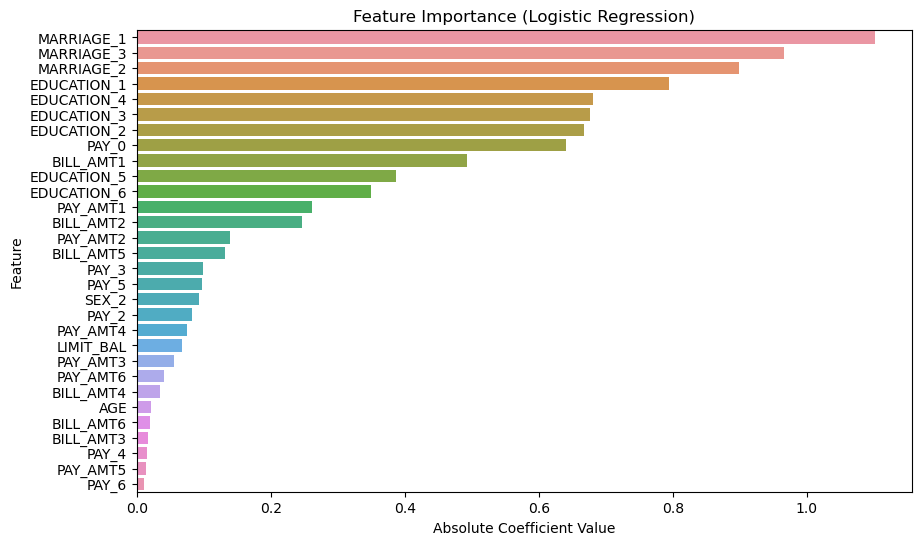

In [80]:
import numpy as np

# Extract feature names after preprocessing
feature_names = numerical_cols + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Get model coefficients
coefficients = model.named_steps['classifier'].coef_[0]

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print feature importance
print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression)')
plt.show()


In [82]:
# Define new train-test split (last 20000 rows for training, first 10000 for testing)
train_data_alt = df.iloc[-20000:]
test_data_alt = df.iloc[:10000]

X_train_alt = train_data_alt.drop(columns=['default.payment.next.month'])
y_train_alt = train_data_alt['default.payment.next.month']

X_test_alt = test_data_alt.drop(columns=['default.payment.next.month'])
y_test_alt = test_data_alt['default.payment.next.month']

# Train the model with the new train-test split
model.fit(X_train_alt, y_train_alt)

# Predictions and evaluation
y_pred_alt = model.predict(X_test_alt)
accuracy_alt = accuracy_score(y_test_alt, y_pred_alt)
report_alt = classification_report(y_test_alt, y_pred_alt, output_dict=True)

# Display new accuracy and classification report
accuracy_alt, report_alt

(0.8027,
 {'0': {'precision': 0.8136828366325864,
   'recall': 0.9664126081901563,
   'f1-score': 0.8834957189253025,
   'support': 7741},
  '1': {'precision': 0.6774193548387096,
   'recall': 0.24169986719787517,
   'f1-score': 0.35628058727569334,
   'support': 2259},
  'accuracy': 0.8027,
  'macro avg': {'precision': 0.745551095735648,
   'recall': 0.6040562376940157,
   'f1-score': 0.6198881531004979,
   'support': 10000},
  'weighted avg': {'precision': 0.7829009160953496,
   'recall': 0.8027,
   'f1-score': 0.7643978206856559,
   'support': 10000}})